In [26]:
# 데이터 전처리

In [45]:
# 보스턴 주택가격 예측2

# 데이터 로드 및 확인

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns= boston.feature_names)

# boston dataset의 target array는 주택 가격. PRICE 컬럼으로 DataFrame에 존재 / 언제나 데이터를 확인하는 습관 (X(data, feature_names), y(target = label))
bostonDF['PRICE'] = boston.target

print(bostonDF.shape)
bostonDF.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [28]:
# 학습/테스트 데이터 분리하고 Linear Regression 학습/예측/평가 수행

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

# 편향/절편 값은 intercept_속성에 저장
# 기울기 파라미터(w)는 가중치/계수라고 하며 coef_속성에 저장
print('절편 값 :',lr.intercept_)
print('회귀 계수값 :', np.round(lr.coef_))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757
절편 값 : 40.995595172164414
회귀 계수값 : [ -0.   0.   0.   3. -20.   3.   0.  -2.   0.  -0.  -1.   0.  -1.]


(506,)


(array([ 21.,  55.,  82., 154.,  84.,  41.,  30.,   8.,  10.,  21.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <BarContainer object of 10 artists>)

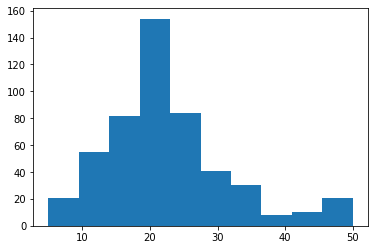

In [29]:
print(y_target.shape)
plt.hist(y_target, bins=10)

In [30]:
# 데이터 전처리(정규화, 로그변환)을 해주는 함수 정의 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음
def get_scaled_data(method=None, p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data) # np.log1p() = np.log(값+1)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias = False).fit_transform(scaled_data)

    return scaled_data

In [31]:
from sklearn.linear_model import Ridge ,Lasso, ElasticNet

# 데이터 프레임 만들기
data=[]

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE와 회귀 계수 반환
def get_linear_reg_eval(model_name, params=None, X_data_n = None, y_target_n=None,
                        verbose=True):
    sub_data=[]
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name, '#######')
    for param in params:
        if model_name == 'Ridge' : model = Ridge(alpha=param)
        elif model_name == 'Lasso' : model = Lasso(alpha=param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                        y_target_n, scoring='neg_mean_squared_error', cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        
        print('alpha {0} 일 때 5 폴드의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
        sub_data.append(np.round(avg_rmse,3))
    data.append(sub_data)

In [32]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]

# 변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ("Standard", None), ("Standard", 2),
                ("MinMax", None), ("MinMax", 2), ("Log", None)]

for scale_method in scale_methods :
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                    input_data=boston.data)
    print(f"\n## 변환 유형:{scale_method[0]}, Polynomial Degree:{scale_method[1]}")

    # alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고,
    # 회귀 계수값들을 DataFrame으로 반환해주는 함수
    get_linear_reg_eval("Ridge", params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1 일 때 5 폴드의 평균 RMSE : 5.788
alpha 1 일 때 5 폴드의 평균 RMSE : 5.653
alpha 10 일 때 5 폴드의 평균 RMSE : 5.518
alpha 100 일 때 5 폴드의 평균 RMSE : 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1 일 때 5 폴드의 평균 RMSE : 5.826
alpha 1 일 때 5 폴드의 평균 RMSE : 5.803
alpha 10 일 때 5 폴드의 평균 RMSE : 5.637
alpha 100 일 때 5 폴드의 평균 RMSE : 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1 일 때 5 폴드의 평균 RMSE : 8.827
alpha 1 일 때 5 폴드의 평균 RMSE : 6.871
alpha 10 일 때 5 폴드의 평균 RMSE : 5.485
alpha 100 일 때 5 폴드의 평균 RMSE : 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1 일 때 5 폴드의 평균 RMSE : 5.764
alpha 1 일 때 5 폴드의 평균 RMSE : 5.465
alpha 10 일 때 5 폴드의 평균 RMSE : 5.754
alpha 100 일 때 5 폴드의 평균 RMSE : 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1 일 때 5 폴드의 평균 RMSE : 5.298
alpha 1 일 때 5 폴드의 평균 RMSE : 4.323
alpha 10 일 때 5 폴드의 평균 RMSE : 5.185
alpha 100 일 때 5 폴드의 평균 RMSE : 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1 일 때 5 폴드의 평균 RMSE : 4.770
alpha 1 일 때 5 폴드의 평균

In [33]:
result_df = pd.DataFrame(data, columns=[["alpha값", "alpha값", "alpha값", "alpha값"], ["alpha=0.1", "alpha=1", "alpha=10", "alpha=100"]])
result_df["변환유형"] = ["원본데이터", "표준정규분포", "표준정규분포 + 2차 다항식", "최솟값/최댓값 정규화", "최솟값/최댓값 정규화 + 2차 다항식", "로그변환"]
result_df.set_index("변환유형", inplace=True)
result_df

alpha값                           
                     alpha=0.1 alpha=1 alpha=10 alpha=100
변환유형                                                     
원본데이터                    5.788   5.653    5.518     5.330
표준정규분포                   5.826   5.803    5.637     5.421
표준정규분포 + 2차 다항식          8.827   6.871    5.485     4.634
최솟값/최댓값 정규화              5.764   5.465    5.754     7.635
최솟값/최댓값 정규화 + 2차 다항식     5.298   4.323    5.185     6.538
로그변환                     4.770   4.676    4.836     6.241

In [34]:
# 로지스틱 회귀
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# 위스콘신 유방암 데이터 불러오기
cancer = load_breast_cancer()

# 데이터 확인하는 습관기르기
df = pd.DataFrame(cancer.data, columns= cancer.feature_names)
df
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(\
    data_scaled, cancer.target, test_size=0.3, random_state=107)

In [36]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc측정
print('accuracy:{:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy:0.988
roc_auc: 0.984


In [46]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

params = {'penalty':['l2','l1'], 'C':[0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring = 'accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


In [47]:
# 랜덤포레스트
# 보스턴 집값 예측

# 데이터 불러오기
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5교차 검증이 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('5교차 검증의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print('5교차 검증의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5교차 검증이 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
5교차 검증의 개별 RMSE scores:  [2.81 3.63 4.54 6.8  4.34]
5교차 검증의 평균 RMSE: 4.423


In [44]:
# 3개 회귀 트리 모델로 회귀 수행

from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_importance, XGBRegressor
import warnings
warnings.filterwarnings('ignore')

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(random_state=0, n_estimators = 1000, learning_rate = 0.1, max_depth=3)

# 함수 설정
def get_model_cv_prediction(model=None, X_data=None, y_target=None) :
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    if model == dt_reg :
        print(f"### DecisionTreeRegressor ### \n5 교차 검증의 평균 RMSE : {np.round(avg_rmse,3)}")
    elif model == rf_reg :
        print(f"### RandomForestRegressor ### \n5 교차 검증의 평균 RMSE : {np.round(avg_rmse,3)}")
    else :
        print(f"### XGBRegressor ### \n5 교차 검증의 평균 RMSE : {np.round(avg_rmse,3)}")

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, xgb_reg]

for model in models:
    get_model_cv_prediction(model, X_data, y_target)

### DecisionTreeRegressor ### 
5 교차 검증의 평균 RMSE : 5.978
### RandomForestRegressor ### 
5 교차 검증의 평균 RMSE : 4.423
### XGBRegressor ### 
5 교차 검증의 평균 RMSE : 4.089


<AxesSubplot:>

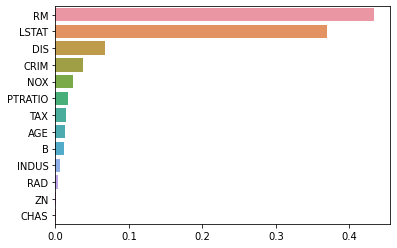

In [43]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용하여 학습
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)
# RM, LSTAT, DIS, CRIM, NOX 변수 선택


In [62]:
import plotly.express as px

# 중요 지표 / RM, LSTAT, DIS, CRIM, NOX 선택

# 보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

# 변수 선정
bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF[['RM','LSTAT','DIS','CRIM','NOX']]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=107)

# 선형회귀 훈련 및 변형
lr = LinearRegression()

lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

# MSE & RMSE & R2
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE :{0:.3f}, RMSE :{1:.3f}'.format(mse, rmse))
print('Variance score:{0:.3f}'.format(r2_score(y_test, y_preds)))

# 시각화
# fig = px.line(bostonDF, x=['RM','LSTAT','DIS','CRIM','NOX'], y='PRICE')
# fig.show()

# fig = px.scatter(bostonDF, x=['RM','LSTAT','DIS','CRIM','NOX'], y='PRICE',
#            marginal_x="box", trendline="ols", template="simple_white")
# fig.show()

fig = px.scatter(bostonDF, x=['NOX'], y='PRICE',
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

bostonDF

MSE :38.051, RMSE :6.169
Variance score:0.481


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [1]:
import FinanceDataReader as fdr

# 2010년~현재까지의 애플 주가를 데이터 프레임으로 불러오기 
df_apple = fdr.DataReader('AAPL', start = '2010')

# 가장 마지막(최신)의 10일치 주가 출력 
df_.tail(10)

df_apple[['Close']].plot(figsize=(20,10)) 
df_apple['Close_7Days_Mean'] = df_apple['Close'].rolling(7).mean()
plt.title('Close Price for Apple')

NameError: name 'df_' is not defined